In [1]:
!pip uninstall numpy -y
!pip install numpy==2.0.0

Found existing installation: numpy 2.0.0
Uninstalling numpy-2.0.0:
  Successfully uninstalled numpy-2.0.0
  Using cached numpy-2.0.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.0.0-cp312-cp312-win_amd64.whl (16.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.0rc2
    Uninstalling numpy-2.0.0rc2:
      Successfully uninstalled numpy-2.0.0rc2



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import librosa.display
import librosa.feature
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
import random
from IPython.display import Audio, display

We make sure that 2.0.0 numpy version is installed

In [3]:
print(np.__version__)

2.0.0


In [4]:
words_set = ["bed", "bird", "cat", "dog", "down",
             "eight", "five", "four", "go", "happy",
             "house", "left", "marvin", "nine", "no",
             "off", "on", "one", "right", "seven",
             "sheila", "six", "stop", "three", "tree",
             "two", "up", "wow", "yes", "zero"]

The dataset audio from unpacked train.7z file is placed in "content/audio" folder

In [6]:
SR = 16000
N_MELS = 128
AUDIO_BASE_PATH = "content/audio"
OUTPUT_BASE_PATH = "content/output"
NOISE_FOLDER = os.path.join(AUDIO_BASE_PATH, "_background_noise_")
IMAGE_SIZE = (224, 224)
SPLIT_BASE_PATH = "content/splits"
TEST_SIZE = 0.20
VAL_SIZE = 0.125

We use 70-10-20 split, but the val_size is 0.125, because it takes 12,5% of the 80% after test split

In [7]:
audio_folders = sorted([
    f for f in os.listdir(AUDIO_BASE_PATH)
    if os.path.isdir(os.path.join(AUDIO_BASE_PATH, f)) and f != "_background_noise_"
])

First we take a random sample to know what we're working on. We trim the audio and create a normalized spectrogram.

Playing: right/fb7c9b3b_nohash_0.wav


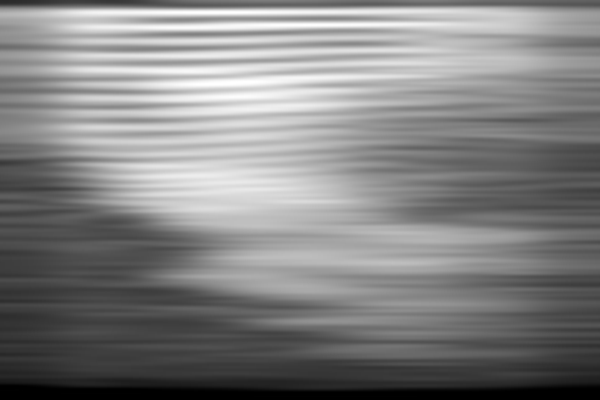

In [19]:
random_folder = random.choice(audio_folders)
folder_path = os.path.join(AUDIO_BASE_PATH, random_folder)
audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
random_audio = random.choice(audio_files)
audio_path = os.path.join(folder_path, random_audio)

samples, sample_rate = librosa.load(audio_path, sr=SR)
samples_trimmed, _ = librosa.effects.trim(samples, top_db=20)

print(f"Playing: {random_folder}/{random_audio}")
display(Audio(data=samples_trimmed, rate=sample_rate))

S = librosa.feature.melspectrogram(y=samples_trimmed, sr=sample_rate, n_mels=N_MELS)
log_S = librosa.power_to_db(S, ref=np.max)
norm_S = ((log_S - log_S.min()) * (255/(log_S.max() - log_S.min()))).astype(np.uint8)


img = Image.fromarray(norm_S)
img = img.resize((600, 400), Image.LANCZOS)

display(img)

In [17]:
def save_plain_mel_spectrogram(y, sr, output_path):

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    log_S = librosa.power_to_db(S, ref=np.max)
    
    norm_S = ((log_S - log_S.min()) * (255/(log_S.max() - log_S.min()))).astype(np.uint8)

    img = Image.fromarray(norm_S)
    img = img.resize(IMAGE_SIZE, Image.LANCZOS)
    img.save(output_path)

In [10]:
for folder in audio_folders:
    os.makedirs(os.path.join(OUTPUT_BASE_PATH, folder), exist_ok=True)

We save yet not splitted spectrograms to folders

In [18]:
for folder in tqdm(audio_folders, desc="Processing folders"):
    folder_path = os.path.join(AUDIO_BASE_PATH, folder)
    output_folder = os.path.join(OUTPUT_BASE_PATH, folder)
    os.makedirs(output_folder, exist_ok=True)
    
    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            y, sr = librosa.load(os.path.join(folder_path, file), sr=SR)
            y_trimmed, _ = librosa.effects.trim(y, top_db=20)
            
            output_path = os.path.join(output_folder, f"{os.path.splitext(file)[0]}.png")
            save_plain_mel_spectrogram(y_trimmed, sr, output_path)

Processing folders:   3%|▎         | 1/30 [04:44<2:17:32, 284.55s/it]C:\Rtemp\ipykernel_16908\1919008739.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  norm_S = ((log_S - log_S.min()) * (255/(log_S.max() - log_S.min()))).astype(np.uint8)
C:\Rtemp\ipykernel_16908\1919008739.py:6: RuntimeWarning: invalid value encountered in multiply
  norm_S = ((log_S - log_S.min()) * (255/(log_S.max() - log_S.min()))).astype(np.uint8)
C:\Rtemp\ipykernel_16908\1919008739.py:6: RuntimeWarning: invalid value encountered in cast
  norm_S = ((log_S - log_S.min()) * (255/(log_S.max() - log_S.min()))).astype(np.uint8)
Processing folders: 100%|██████████| 30/30 [3:28:53<00:00, 417.79s/it]  


In [21]:
yes_no_words = ["yes", "no"]
os.makedirs(os.path.join(SPLIT_BASE_PATH, "split_yes_no"), exist_ok=True)

In [22]:
ten_words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
os.makedirs(os.path.join(SPLIT_BASE_PATH, "split_10"), exist_ok=True)

In [23]:
other_words = [w for w in words_set if w not in ten_words]
os.makedirs(os.path.join(SPLIT_BASE_PATH, "split_10_unknown"), exist_ok=True)

In [24]:
UNKNOWN_SAMPLE_RATIO = 0.05  # 5% of unknown samples
MIN_UNKNOWN_SAMPLES = 2  # minimum samples per unknown word

We create four different splits:
- yes/no split
- 10 words split
- 10 words with unknown split
- 10 words with balanced unknown split

In [29]:
def create_splits(class_list, split_name, include_unknown=False, balance_unknown=False):
    base_path = os.path.join(SPLIT_BASE_PATH, split_name)

    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(base_path, split), exist_ok=True)
        for cls in class_list + (['unknown'] if include_unknown else []):
            os.makedirs(os.path.join(base_path, split, cls), exist_ok=True)

    # known classes
    for cls in tqdm(class_list, desc=f"Processing {split_name} classes"):
        src_dir = os.path.join(OUTPUT_BASE_PATH, cls)  # (spectrograms)
        files = [f for f in os.listdir(src_dir) if f.endswith('.png')]

        # first split - test vs train+val
        train_val_files, test_files = train_test_split(files, test_size=TEST_SIZE, random_state=42)

        # second split - train vs val (with 12,5% val_size mentioned before in the markdown cell)
        train_files, val_files = train_test_split(train_val_files, test_size=VAL_SIZE, random_state=42)

        # copying files
        for file in train_files:
            shutil.copy2(os.path.join(src_dir, file),
                        os.path.join(base_path, 'train', cls, file))
        for file in val_files:
            shutil.copy2(os.path.join(src_dir, file),
                        os.path.join(base_path, 'val', cls, file))
        for file in test_files:
            shutil.copy2(os.path.join(src_dir, file),
                        os.path.join(base_path, 'test', cls, file))

    # unknown class
    if include_unknown:
        unknown_files = []
        for cls in other_words:
            src_dir = os.path.join(OUTPUT_BASE_PATH, cls)
            if not os.path.exists(src_dir):
                continue
            cls_files = [f for f in os.listdir(src_dir) if f.endswith('.png')]

            if balance_unknown:
                # take 5% of samples only
                n_samples = max(MIN_UNKNOWN_SAMPLES, int(len(cls_files) * UNKNOWN_SAMPLE_RATIO))
                sampled_files = np.random.choice(cls_files, size=min(n_samples, len(cls_files)), replace=False)
                unknown_files.extend([(cls, f) for f in sampled_files])
            else:
                unknown_files.extend([(cls, f) for f in cls_files])

        if unknown_files:  # only proceed if we have unknown files
            train_val_unk, test_unk = train_test_split(unknown_files, test_size=TEST_SIZE, random_state=42)
            train_unk, val_unk = train_test_split(train_val_unk, test_size=VAL_SIZE, random_state=42)

            for i, (cls, file) in enumerate(train_unk):
                shutil.copy2(os.path.join(OUTPUT_BASE_PATH, cls, file),  
                            os.path.join(base_path, 'train', 'unknown', f"{cls}_{file}"))
            for i, (cls, file) in enumerate(val_unk):
                shutil.copy2(os.path.join(OUTPUT_BASE_PATH, cls, file),  
                            os.path.join(base_path, 'val', 'unknown', f"{cls}_{file}"))
            for i, (cls, file) in enumerate(test_unk):
                shutil.copy2(os.path.join(OUTPUT_BASE_PATH, cls, file),  
                            os.path.join(base_path, 'test', 'unknown', f"{cls}_{file}"))

In [30]:
create_splits(yes_no_words, "split_yes_no")

Processing split_yes_no classes: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


In [31]:
create_splits(ten_words, "split_10")

Processing split_10 classes: 100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


In [32]:
create_splits(ten_words, "split_10_unknown", include_unknown=True)

Processing split_10_unknown classes: 100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


In [33]:
create_splits(ten_words, "split_10_unknown_balanced", include_unknown=True, balance_unknown=True)

Processing split_10_unknown_balanced classes: 100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


In [34]:
def verify_splits():

    for split_name in ["split_yes_no", "split_10", "split_10_unknown", "split_10_unknown_balanced"]:
        print(f"\n{split_name.upper()} Distribution:")
        split_path = os.path.join(SPLIT_BASE_PATH, split_name)
        for split in ['train', 'val', 'test']:
            print(f"\n{split}:")
            for cls in sorted(os.listdir(os.path.join(split_path, split))):
                count = len(os.listdir(os.path.join(split_path, split, cls)))
                print(f"{cls}: {count} samples")

verify_splits()


SPLIT_YES_NO Distribution:

train:
no: 1662 samples
yes: 1663 samples

val:
no: 238 samples
yes: 238 samples

test:
no: 475 samples
yes: 476 samples

SPLIT_10 Distribution:

train:
down: 1651 samples
go: 1659 samples
left: 1646 samples
no: 1662 samples
off: 1649 samples
on: 1656 samples
right: 1656 samples
stop: 1666 samples
up: 1662 samples
yes: 1663 samples

val:
down: 236 samples
go: 238 samples
left: 236 samples
no: 238 samples
off: 236 samples
on: 237 samples
right: 237 samples
stop: 238 samples
up: 238 samples
yes: 238 samples

test:
down: 472 samples
go: 475 samples
left: 471 samples
no: 475 samples
off: 472 samples
on: 474 samples
right: 474 samples
stop: 476 samples
up: 475 samples
yes: 476 samples

SPLIT_10_UNKNOWN Distribution:

train:
down: 1651 samples
go: 1659 samples
left: 1646 samples
no: 1662 samples
off: 1649 samples
on: 1656 samples
right: 1656 samples
stop: 1666 samples
unknown: 28727 samples
up: 1662 samples
yes: 1663 samples

val:
down: 236 samples
go: 238 sample

In [36]:
def show_random_sample(split_name="split_10"):
    split_path = os.path.join(SPLIT_BASE_PATH, split_name, 'train')
    classes = os.listdir(split_path)
    random_class = np.random.choice(classes)
    random_file = np.random.choice(os.listdir(os.path.join(split_path, random_class)))

    img = plt.imread(os.path.join(split_path, random_class, random_file))
    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap='viridis')
    plt.title(f"{random_class} sample")
    plt.axis('off')
    plt.show()

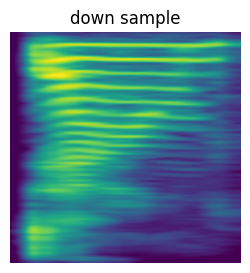

In [37]:
show_random_sample()

The spectrogram splits are available here: https://drive.google.com/drive/folders/15HZo91ICZeF6-bYuRl0OQEgLq6Ms89hl?usp=sharing